In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import Left, Interval
import datetime

In [37]:
STORE_PATH = '/home/pstefanou/fewerEpochs'
STORE_TABLE_NAME = 'fewepochs2'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float, 
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

Logging in: /home/pstefanou/fewerEpochs/778743fb-d5bf-45f1-93fe-f12ab3a582a1


In [38]:
# regression parameters
num_samples, dims = 10000, 10
W = ch.ones(dims, 1)
W0 = ch.ones(1, 1)
phi = Left(Tensor([1.0]))

# begin experiment
start = datetime.datetime.now()

# perform each experiment a total of 10 times
for iter_ in range(10):        
    for var in range(1, 20):
        # generate data
        X = MultivariateNormal(ch.zeros(dims), ch.eye(dims)/dims).sample(ch.Size([num_samples]))
        y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([num_samples]))
        # truncate
        indices = phi(y).nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = y[indices], X[indices]
        
        # empirical linear regression
        reg = LinearRegression() 
        reg.fit(x_trunc, y_trunc)
        emp_var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)
        
        # experiment parameters
        args = Parameters({ 
            'alpha': Tensor([y_trunc.size(0)/num_samples]), 
            'phi': phi, 
            'epochs': 10,
            'num_workers': 20, 
            'batch_size': 100,
            'bias': True,
            'num_samples': 100,
            'clamp': True, 
            'radius': 5.0, 
            'var_lr': 1e-2,
            'var': emp_var,
            'lr': 1e-1,
            'shuffle': True
        })


        # truncated linear regression with known noise variance
        # dataset 
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples, var=args.var)
        results = trunc_reg.fit(S)
        w_, w0_ = results.weight.detach(), results.bias.detach()

        # truncated linear regression with unknown noise variance
        # dataset 
        data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=True)
        S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
        trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, var_lr=args.var_lr, lr=args.lr, num_samples=args.num_samples)

        results = trunc_reg.fit(S)
        var_ = results.lambda_.inverse().detach()
        w, w0 = results.v.detach()*var_, results.bias.detach()*var_
        
        # calculate metrics 
        real_params = ch.cat([W, W0])
        ols_params = ch.cat([data.w, data.w0.unsqueeze(0)])
        unknown_params = ch.cat([w, w0])
        known_params = ch.cat([w_.t(), w0_.unsqueeze(0)])
        unknown_param_mse = mean_squared_error(unknown_params, real_params)
        ols_param_mse = mean_squared_error(ols_params, real_params)
        known_param_mse = mean_squared_error(known_params, real_params)

        store[STORE_TABLE_NAME].append_row({ 
            'known_param_mse': known_param_mse,
            'unknown_param_mse': unknown_param_mse,
            'ols_param_mse': ols_param_mse,
            'alpha': float(args.alpha.flatten()),
            'var': float(var), 
        })

# end experiment
end = datetime.datetime.now()
print("time delta: {}".format(end - start))

# close current store
store.close()

Epoch:1 | Loss 0.2649 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 101.50it/s]
Epoch:2 | Loss 0.2696 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 98.85it/s] 
Epoch:3 | Loss 0.2776 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 94.06it/s]
Epoch:4 | Loss 0.2808 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 93.86it/s]
Epoch:5 | Loss 0.2842 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 102.83it/s]
Epoch:6 | Loss 0.2849 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 101.07it/s]
Epoch:7 | Loss 0.2852 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 94.95it/s]
Epoch:8 | Loss 0.2871 | Train1 0.273 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 107.25it/s]
Epoch:9 | Loss 0.2895 | Tra

Epoch:8 | Loss 0.8919 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 86.26it/s]
Epoch:9 | Loss 0.8945 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 81.50it/s]
Epoch:10 | Loss 0.8940 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 88.78it/s]
Epoch:1 | Loss 0.8247 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 55.82it/s]
Epoch:2 | Loss 0.8442 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 53.79it/s]
Epoch:3 | Loss 0.8898 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.37it/s]
Epoch:4 | Loss 0.9355 | Train1 0.184 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 44.83it/s]
Epoch:5 | Loss 0.9941 | Train1 0.184 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.02it/s]
Epoch:6 | Loss 1.0363 | Train1 

Epoch:5 | Loss 2.0450 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.08it/s]
Epoch:6 | Loss 2.2993 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 58.35it/s]
Epoch:7 | Loss 2.4117 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.51it/s]
Epoch:8 | Loss 2.6757 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 48.88it/s]
Epoch:9 | Loss 2.7643 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.35it/s]
Epoch:10 | Loss 2.7248 | Train1 0.130 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.62it/s]
Epoch:1 | Loss 1.5247 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 76.09it/s]
Epoch:2 | Loss 1.5583 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 98.32it/s]
Epoch:3 | Loss 1.6148 | Train1 

Epoch:2 | Loss 2.1144 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 94.90it/s] 
Epoch:3 | Loss 2.2042 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 104.49it/s]
Epoch:4 | Loss 2.2116 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 100.93it/s]
Epoch:5 | Loss 2.2317 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 105.34it/s]
Epoch:6 | Loss 2.2350 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 104.11it/s]
Epoch:7 | Loss 2.2192 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 86.88it/s]
Epoch:8 | Loss 2.2244 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 105.44it/s]
Epoch:9 | Loss 2.2391 | Train1 0.114 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 100.96it/s]
Epoch:10 | Loss 2.2318 | 

Epoch:9 | Loss 2.8980 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 91.24it/s]
Epoch:10 | Loss 2.9081 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 86.47it/s]
Epoch:1 | Loss 2.6829 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 47.13it/s]
Epoch:2 | Loss 2.9295 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.88it/s]
Epoch:3 | Loss 4.1534 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.71it/s]
Epoch:4 | Loss 5.1627 | Train1 0.094 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.52it/s]
Epoch:5 | Loss 5.1787 | Train1 0.094 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.95it/s]
Epoch:6 | Loss 5.3559 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 51.58it/s]
Epoch:7 | Loss 6.1805 | Train1 

Epoch:6 | Loss 6.0229 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 58.65it/s]
Epoch:7 | Loss 6.8621 | Train1 0.095 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.32it/s]
Epoch:8 | Loss 6.4140 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.06it/s]
Epoch:9 | Loss 6.9793 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.74it/s]
Epoch:10 | Loss 7.3848 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 48.30it/s]
Epoch:1 | Loss 3.2667 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 79.96it/s]
Epoch:2 | Loss 3.3562 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 87.67it/s]
Epoch:3 | Loss 3.4543 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 86.26it/s]
Epoch:4 | Loss 3.5130 | Train1 

Epoch:3 | Loss 0.4975 | Train1 0.222 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 101.42it/s]
Epoch:4 | Loss 0.5008 | Train1 0.222 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 97.90it/s] 
Epoch:5 | Loss 0.5044 | Train1 0.222 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 105.88it/s]
Epoch:6 | Loss 0.5036 | Train1 0.222 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 102.40it/s]
Epoch:7 | Loss 0.5058 | Train1 0.222 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 102.47it/s]
Epoch:8 | Loss 0.5073 | Train1 0.222 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 103.05it/s]
Epoch:9 | Loss 0.5081 | Train1 0.222 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 104.49it/s]
Epoch:10 | Loss 0.5092 | Train1 0.222 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 102.86it/s]
Epoch:1 | Loss 0.4687 |

Epoch:10 | Loss 1.1153 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 98.50it/s] 
Epoch:1 | Loss 1.0206 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.41it/s]
Epoch:2 | Loss 1.0684 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 58.19it/s]
Epoch:3 | Loss 1.1418 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 57.29it/s]
Epoch:4 | Loss 1.2256 | Train1 0.165 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.12it/s]
Epoch:5 | Loss 1.4208 | Train1 0.163 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 57.83it/s]
Epoch:6 | Loss 1.5086 | Train1 0.161 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 57.43it/s]
Epoch:7 | Loss 1.6637 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 61.89it/s]
Epoch:8 | Loss 1.7355 | Train1

Epoch:7 | Loss 3.5417 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.30it/s]
Epoch:8 | Loss 3.5887 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 51.76it/s]
Epoch:9 | Loss 3.5440 | Train1 0.119 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 51.63it/s]
Epoch:10 | Loss 3.6158 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.88it/s]
Epoch:1 | Loss 1.7290 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 73.90it/s]
Epoch:2 | Loss 1.7662 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 89.90it/s]
Epoch:3 | Loss 1.8450 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 82.67it/s]
Epoch:4 | Loss 1.8646 | Train1 0.126 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 89.00it/s]
Epoch:5 | Loss 1.8654 | Train1 

Epoch:4 | Loss 2.6475 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 102.69it/s]
Epoch:5 | Loss 2.6537 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 104.03it/s]
Epoch:6 | Loss 2.6625 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 104.79it/s]
Epoch:7 | Loss 2.6307 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 104.74it/s]
Epoch:8 | Loss 2.6545 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 104.66it/s]
Epoch:9 | Loss 2.6575 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 102.24it/s]
Epoch:10 | Loss 2.6554 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 106.50it/s]
Epoch:1 | Loss 2.4447 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 57.43it/s]
Epoch:2 | Loss 2.6487 | 

Epoch:1 | Loss 2.8300 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.34it/s]
Epoch:2 | Loss 3.0461 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 51.16it/s]
Epoch:3 | Loss 4.4293 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 62.44it/s]
Epoch:4 | Loss 5.0030 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 48.60it/s]
Epoch:5 | Loss 5.0311 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.64it/s]
Epoch:6 | Loss 5.2472 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 46.80it/s]
Epoch:7 | Loss 5.2506 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 51.33it/s]
Epoch:8 | Loss 5.4807 | Train1 0.095 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.25it/s]
Epoch:9 | Loss 5.4601 | Train1 0

Epoch:8 | Loss 7.2819 | Train1 0.082 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.45it/s]
Epoch:9 | Loss 7.5449 | Train1 0.080 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.62it/s]
Epoch:10 | Loss 7.6397 | Train1 0.079 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 60.82it/s]
Epoch:1 | Loss 3.5731 | Train1 0.087 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 91.41it/s]
Epoch:2 | Loss 3.6608 | Train1 0.087 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 73.48it/s]
Epoch:3 | Loss 3.8184 | Train1 0.087 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 82.08it/s]
Epoch:4 | Loss 3.8441 | Train1 0.087 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 78.73it/s]
Epoch:5 | Loss 3.8415 | Train1 0.087 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 83.82it/s]
Epoch:6 | Loss 3.8605 | Train1 

Epoch:5 | Loss 0.6742 | Train1 0.206 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 74.35it/s]
Epoch:6 | Loss 0.6911 | Train1 0.206 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 100.82it/s]
Epoch:7 | Loss 0.6873 | Train1 0.206 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 82.43it/s]
Epoch:8 | Loss 0.6862 | Train1 0.206 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 88.04it/s]
Epoch:9 | Loss 0.6921 | Train1 0.206 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 91.46it/s]
Epoch:10 | Loss 0.6945 | Train1 0.206 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 95.89it/s]
Epoch:1 | Loss 0.6295 | Train1 0.206 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 49.36it/s]
Epoch:2 | Loss 0.6472 | Train1 0.206 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 59.11it/s]
Epoch:3 | Loss 0.6712 | Train1

Epoch:2 | Loss 1.3014 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.51it/s]
Epoch:3 | Loss 1.3967 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.11it/s]
Epoch:4 | Loss 1.6317 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.80it/s]
Epoch:5 | Loss 1.9074 | Train1 0.139 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.40it/s]
Epoch:6 | Loss 2.0862 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 53.32it/s]
Epoch:7 | Loss 2.3795 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 55.96it/s]
Epoch:8 | Loss 2.5226 | Train1 0.132 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.26it/s]
Epoch:9 | Loss 2.4820 | Train1 0.131 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.92it/s]
Epoch:10 | Loss 2.5688 | Train1 

Epoch:9 | Loss 4.2479 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.63it/s]
Epoch:10 | Loss 4.3289 | Train1 0.110 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.12it/s]
Epoch:1 | Loss 1.9363 | Train1 0.118 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 103.32it/s]
Epoch:2 | Loss 1.9790 | Train1 0.118 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 108.70it/s]
Epoch:3 | Loss 2.0636 | Train1 0.118 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 98.58it/s] 
Epoch:4 | Loss 2.0659 | Train1 0.118 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 99.23it/s] 
Epoch:5 | Loss 2.0780 | Train1 0.118 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 91.46it/s] 
Epoch:6 | Loss 2.0723 | Train1 0.118 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 96.20it/s]
Epoch:7 | Loss 2.0822 | Tr

Epoch:6 | Loss 2.6629 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 81.47it/s]
Epoch:7 | Loss 2.6484 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 83.47it/s]
Epoch:8 | Loss 2.6642 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 83.59it/s]
Epoch:9 | Loss 2.6460 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 77.08it/s]
Epoch:10 | Loss 2.6656 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 84.67it/s]
Epoch:1 | Loss 2.4665 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 46.20it/s]
Epoch:2 | Loss 2.6526 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.83it/s]
Epoch:3 | Loss 3.7866 | Train1 0.104 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 59.92it/s]
Epoch:4 | Loss 4.3516 | Train1 

Epoch:3 | Loss 4.8481 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 59.04it/s]
Epoch:4 | Loss 5.0557 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 52.57it/s]
Epoch:5 | Loss 5.4158 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 56.88it/s]
Epoch:6 | Loss 5.4725 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.20it/s]
Epoch:7 | Loss 5.8350 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.26it/s]
Epoch:8 | Loss 5.5388 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 56.79it/s]
Epoch:9 | Loss 5.9308 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.20it/s]
Epoch:10 | Loss 6.2939 | Train1 0.095 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 59.95it/s]
Epoch:1 | Loss 3.2030 | Train1 

Epoch:10 | Loss 7.6799 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 57.21it/s]
Epoch:1 | Loss 0.2651 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 78.01it/s]
Epoch:2 | Loss 0.2704 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 89.36it/s]
Epoch:3 | Loss 0.2781 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 81.87it/s]
Epoch:4 | Loss 0.2811 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 76.69it/s]
Epoch:5 | Loss 0.2844 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 85.38it/s]
Epoch:6 | Loss 0.2855 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 79.50it/s]
Epoch:7 | Loss 0.2865 | Train1 0.278 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 97.01it/s] 
Epoch:8 | Loss 0.2879 | Train1

Epoch:7 | Loss 0.9005 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 103.45it/s]
Epoch:8 | Loss 0.9018 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 100.27it/s]
Epoch:9 | Loss 0.9007 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 101.98it/s]
Epoch:10 | Loss 0.8957 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 106.04it/s]
Epoch:1 | Loss 0.8263 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.68it/s]
Epoch:2 | Loss 0.8501 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.15it/s]
Epoch:3 | Loss 0.8916 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 56.72it/s]
Epoch:4 | Loss 0.9315 | Train1 0.176 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.12it/s]
Epoch:5 | Loss 0.9841 | Tra

Epoch:4 | Loss 1.8863 | Train1 0.147 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 58.74it/s]
Epoch:5 | Loss 2.2008 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 60.43it/s]
Epoch:6 | Loss 2.4208 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.74it/s]
Epoch:7 | Loss 2.5873 | Train1 0.141 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.10it/s]
Epoch:8 | Loss 2.7960 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.70it/s]
Epoch:9 | Loss 2.8704 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 51.91it/s]
Epoch:10 | Loss 3.0176 | Train1 0.131 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.90it/s]
Epoch:1 | Loss 1.5744 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 80.25it/s]
Epoch:2 | Loss 1.6066 | Train1 

Epoch:1 | Loss 2.1487 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 93.22it/s]
Epoch:2 | Loss 2.2040 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 79.15it/s]
Epoch:3 | Loss 2.2835 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 75.96it/s]
Epoch:4 | Loss 2.3017 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 92.85it/s]
Epoch:5 | Loss 2.2908 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 97.86it/s]
Epoch:6 | Loss 2.3257 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 70.58it/s]
Epoch:7 | Loss 2.3063 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 86.54it/s]
Epoch:8 | Loss 2.3271 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 86.61it/s]
Epoch:9 | Loss 2.3163 | Train1 0

Epoch:8 | Loss 2.9729 | Train1 0.103 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 86.63it/s]
Epoch:9 | Loss 2.9807 | Train1 0.103 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 77.74it/s]
Epoch:10 | Loss 2.9862 | Train1 0.103 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 80.08it/s]
Epoch:1 | Loss 2.7619 | Train1 0.103 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 47.31it/s]
Epoch:2 | Loss 3.0452 | Train1 0.103 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 48.70it/s]
Epoch:3 | Loss 4.3710 | Train1 0.103 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 47.11it/s]
Epoch:4 | Loss 5.5301 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 49.31it/s]
Epoch:5 | Loss 5.6499 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 50.22it/s]
Epoch:6 | Loss 6.3247 | Train1 

Epoch:5 | Loss 5.2570 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:01<00:00, 48.12it/s]
Epoch:6 | Loss 5.1456 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:01<00:00, 43.46it/s]
Epoch:7 | Loss 6.1421 | Train1 0.095 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 59.60it/s]
Epoch:8 | Loss 6.6430 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 56.08it/s]
Epoch:9 | Loss 6.9779 | Train1 0.093 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 53.02it/s]
Epoch:10 | Loss 7.1232 | Train1 0.091 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 56.10it/s]
Epoch:1 | Loss 3.3775 | Train1 0.085 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 108.85it/s]
Epoch:2 | Loss 3.4549 | Train1 0.085 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 104.73it/s]
Epoch:3 | Loss 3.5826 | Train

Epoch:2 | Loss 0.4774 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 84.39it/s]
Epoch:3 | Loss 0.4965 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 86.55it/s]
Epoch:4 | Loss 0.5052 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 94.60it/s]
Epoch:5 | Loss 0.5058 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 87.40it/s]
Epoch:6 | Loss 0.5062 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 76.07it/s]
Epoch:7 | Loss 0.5127 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 81.53it/s]
Epoch:8 | Loss 0.5118 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 85.41it/s]
Epoch:9 | Loss 0.5174 | Train1 0.226 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 80.69it/s]
Epoch:10 | Loss 0.5178 | Train1 

Epoch:9 | Loss 1.1146 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 77.86it/s]
Epoch:10 | Loss 1.1168 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 80.23it/s]
Epoch:1 | Loss 1.0296 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.84it/s]
Epoch:2 | Loss 1.0669 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.61it/s]
Epoch:3 | Loss 1.1378 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.90it/s]
Epoch:4 | Loss 1.2456 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.15it/s]
Epoch:5 | Loss 1.3733 | Train1 0.159 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.27it/s]
Epoch:6 | Loss 1.4862 | Train1 0.158 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 51.59it/s]
Epoch:7 | Loss 1.5233 | Train1 

Epoch:6 | Loss 3.5350 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 60.83it/s]
Epoch:7 | Loss 3.8499 | Train1 0.132 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 51.83it/s]
Epoch:8 | Loss 4.0931 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 57.16it/s]
Epoch:9 | Loss 4.1012 | Train1 0.125 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.94it/s]
Epoch:10 | Loss 4.3056 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.38it/s]
Epoch:1 | Loss 1.7309 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 85.63it/s]
Epoch:2 | Loss 1.7760 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 93.12it/s]
Epoch:3 | Loss 1.8398 | Train1 0.128 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 86.87it/s]
Epoch:4 | Loss 1.8470 | Train1 

Epoch:3 | Loss 2.5196 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 79.21it/s]
Epoch:4 | Loss 2.5303 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 104.11it/s]
Epoch:5 | Loss 2.5317 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 105.48it/s]
Epoch:6 | Loss 2.5409 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 101.36it/s]
Epoch:7 | Loss 2.5328 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 105.69it/s]
Epoch:8 | Loss 2.5627 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 101.01it/s]
Epoch:9 | Loss 2.5430 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 103.45it/s]
Epoch:10 | Loss 2.5426 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 101.05it/s]
Epoch:1 | Loss 2.3558 | 

Epoch:10 | Loss 2.9555 | Train1 0.102 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 84.84it/s]
Epoch:1 | Loss 2.7460 | Train1 0.102 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.78it/s]
Epoch:2 | Loss 2.9929 | Train1 0.102 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 50.02it/s]
Epoch:3 | Loss 4.4125 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.33it/s]
Epoch:4 | Loss 4.4105 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 51.40it/s]
Epoch:5 | Loss 4.9022 | Train1 0.099 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.86it/s]
Epoch:6 | Loss 4.7737 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.58it/s]
Epoch:7 | Loss 5.2682 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.42it/s]
Epoch:8 | Loss 5.5810 | Train1 

Epoch:7 | Loss 5.7546 | Train1 0.093 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 56.99it/s]
Epoch:8 | Loss 6.3854 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 50.89it/s]
Epoch:9 | Loss 7.2162 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 51.87it/s]
Epoch:10 | Loss 7.0409 | Train1 0.091 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 55.47it/s]
Epoch:1 | Loss 3.5123 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 97.90it/s]
Epoch:2 | Loss 3.6045 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 86.32it/s]
Epoch:3 | Loss 3.7356 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 75.59it/s]
Epoch:4 | Loss 3.7189 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 81.77it/s]
Epoch:5 | Loss 3.7753 | Train1 

Epoch:4 | Loss 0.7242 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 85.36it/s]
Epoch:5 | Loss 0.7226 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 87.63it/s]
Epoch:6 | Loss 0.7295 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 91.97it/s]
Epoch:7 | Loss 0.7275 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 83.04it/s]
Epoch:8 | Loss 0.7335 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 90.15it/s]
Epoch:9 | Loss 0.7381 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 84.22it/s]
Epoch:10 | Loss 0.7367 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 75.47it/s]
Epoch:1 | Loss 0.6672 | Train1 0.207 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.09it/s]
Epoch:2 | Loss 0.6877 | Train1 

Epoch:1 | Loss 1.1645 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 61.23it/s]
Epoch:2 | Loss 1.2130 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.33it/s]
Epoch:3 | Loss 1.2812 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 59.61it/s]
Epoch:4 | Loss 1.4390 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.36it/s]
Epoch:5 | Loss 1.5616 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.89it/s]
Epoch:6 | Loss 1.6981 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.33it/s]
Epoch:7 | Loss 1.7358 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.07it/s]
Epoch:8 | Loss 1.9323 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 51.31it/s]
Epoch:9 | Loss 2.0194 | Train1 0

Epoch:8 | Loss 3.6522 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.97it/s]
Epoch:9 | Loss 4.1094 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 59.90it/s]
Epoch:10 | Loss 4.1252 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 60.43it/s]
Epoch:1 | Loss 1.9522 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 99.30it/s] 
Epoch:2 | Loss 1.9977 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 104.59it/s]
Epoch:3 | Loss 2.0707 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 99.98it/s] 
Epoch:4 | Loss 2.0968 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 102.68it/s]
Epoch:5 | Loss 2.0921 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 91.43it/s] 
Epoch:6 | Loss 2.0931 | Tr

Epoch:5 | Loss 2.5483 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 108.95it/s]
Epoch:6 | Loss 2.5566 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 100.96it/s]
Epoch:7 | Loss 2.5678 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 102.07it/s]
Epoch:8 | Loss 2.5707 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 103.04it/s]
Epoch:9 | Loss 2.5503 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 102.48it/s]
Epoch:10 | Loss 2.5587 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 103.78it/s]
Epoch:1 | Loss 2.3688 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 59.21it/s]
Epoch:2 | Loss 2.5764 | Train1 0.111 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 59.48it/s]
Epoch:3 | Loss 3.4535 | T

Epoch:2 | Loss 3.4067 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 52.90it/s]
Epoch:3 | Loss 4.9223 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.26it/s]
Epoch:4 | Loss 5.0301 | Train1 0.091 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 56.65it/s]
Epoch:5 | Loss 4.7694 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 50.83it/s]
Epoch:6 | Loss 5.3315 | Train1 0.091 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.37it/s]
Epoch:7 | Loss 6.3396 | Train1 0.089 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 44.93it/s]
Epoch:8 | Loss 6.5036 | Train1 0.087 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 55.24it/s]
Epoch:9 | Loss 6.9669 | Train1 0.083 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 51.38it/s]
Epoch:10 | Loss 6.6711 | Train1 

Epoch:9 | Loss 7.0331 | Train1 0.085 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 59.29it/s]
Epoch:10 | Loss 7.8620 | Train1 0.083 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.46it/s]
Epoch:1 | Loss 0.2653 | Train1 0.281 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 111.45it/s]
Epoch:2 | Loss 0.2712 | Train1 0.281 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 104.88it/s]
Epoch:3 | Loss 0.2790 | Train1 0.281 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 101.58it/s]
Epoch:4 | Loss 0.2837 | Train1 0.281 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 101.69it/s]
Epoch:5 | Loss 0.2872 | Train1 0.281 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 106.98it/s]
Epoch:6 | Loss 0.2880 | Train1 0.281 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 102.52it/s]
Epoch:7 | Loss 0.2882 | T

Epoch:6 | Loss 0.8975 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 102.50it/s]
Epoch:7 | Loss 0.9059 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 96.71it/s] 
Epoch:8 | Loss 0.8975 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 103.48it/s]
Epoch:9 | Loss 0.9096 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 106.02it/s]
Epoch:10 | Loss 0.9056 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 103.83it/s]
Epoch:1 | Loss 0.8261 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 56.07it/s]
Epoch:2 | Loss 0.8562 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.84it/s]
Epoch:3 | Loss 0.9018 | Train1 0.185 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 53.73it/s]
Epoch:4 | Loss 0.9595 | Tr

Epoch:3 | Loss 1.6857 | Train1 0.140 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.26it/s]
Epoch:4 | Loss 2.0612 | Train1 0.139 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.98it/s]
Epoch:5 | Loss 2.5750 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 59.68it/s]
Epoch:6 | Loss 1.9173 | Train1 0.139 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 60.00it/s]
Epoch:7 | Loss 2.0533 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 58.46it/s]
Epoch:8 | Loss 2.2006 | Train1 0.138 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 60.38it/s]
Epoch:9 | Loss 2.3719 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.50it/s]
Epoch:10 | Loss 2.4262 | Train1 0.136 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 58.01it/s]
Epoch:1 | Loss 1.6063 | Train1 

Epoch:10 | Loss 3.5447 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 59.32it/s]
Epoch:1 | Loss 2.2003 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 79.44it/s]
Epoch:2 | Loss 2.2568 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 85.83it/s]
Epoch:3 | Loss 2.3511 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 75.98it/s]
Epoch:4 | Loss 2.3699 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 95.98it/s]
Epoch:5 | Loss 2.3724 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 100.88it/s]
Epoch:6 | Loss 2.3873 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 101.23it/s]
Epoch:7 | Loss 2.3773 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 92.68it/s]
Epoch:8 | Loss 2.3871 | Train

Epoch:7 | Loss 2.8169 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 90.54it/s]
Epoch:8 | Loss 2.8191 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 88.78it/s]
Epoch:9 | Loss 2.8056 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 82.13it/s]
Epoch:10 | Loss 2.8225 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 86.62it/s]
Epoch:1 | Loss 2.6177 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 47.40it/s]
Epoch:2 | Loss 2.8392 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.23it/s]
Epoch:3 | Loss 3.9746 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 55.34it/s]
Epoch:4 | Loss 4.3021 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 52.30it/s]
Epoch:5 | Loss 4.6143 | Train1 

Epoch:4 | Loss 5.0574 | Train1 0.095 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 52.72it/s]
Epoch:5 | Loss 5.9688 | Train1 0.094 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 52.13it/s]
Epoch:6 | Loss 4.7153 | Train1 0.094 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 55.41it/s]
Epoch:7 | Loss 6.0445 | Train1 0.094 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 56.29it/s]
Epoch:8 | Loss 6.3858 | Train1 0.094 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 53.66it/s]
Epoch:9 | Loss 6.7562 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.37it/s]
Epoch:10 | Loss 6.9986 | Train1 0.091 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 51.70it/s]
Epoch:1 | Loss 3.4817 | Train1 0.090 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 99.76it/s]
Epoch:2 | Loss 3.5666 | Train1 

Epoch:1 | Loss 0.4414 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 98.06it/s] 
Epoch:2 | Loss 0.4513 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 103.65it/s]
Epoch:3 | Loss 0.4656 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 93.62it/s] 
Epoch:4 | Loss 0.4695 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 101.10it/s]
Epoch:5 | Loss 0.4745 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 110.76it/s]
Epoch:6 | Loss 0.4774 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 105.45it/s]
Epoch:7 | Loss 0.4765 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 103.22it/s]
Epoch:8 | Loss 0.4748 | Train1 0.215 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 98.00it/s] 
Epoch:9 | Loss 0.4825 | 

Epoch:8 | Loss 1.0628 | Train1 0.161 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 77.33it/s]
Epoch:9 | Loss 1.0660 | Train1 0.161 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 88.19it/s]
Epoch:10 | Loss 1.0666 | Train1 0.161 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 94.37it/s]
Epoch:1 | Loss 0.9795 | Train1 0.161 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 50.77it/s]
Epoch:2 | Loss 1.0189 | Train1 0.161 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.83it/s]
Epoch:3 | Loss 1.0776 | Train1 0.161 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.80it/s]
Epoch:4 | Loss 1.1622 | Train1 0.161 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.62it/s]
Epoch:5 | Loss 1.2882 | Train1 0.160 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.11it/s]
Epoch:6 | Loss 1.3628 | Train1 

Epoch:5 | Loss 2.6884 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.74it/s]
Epoch:6 | Loss 2.5412 | Train1 0.135 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.04it/s]
Epoch:7 | Loss 2.5723 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.10it/s]
Epoch:8 | Loss 2.6079 | Train1 0.134 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.22it/s]
Epoch:9 | Loss 2.9367 | Train1 0.133 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.78it/s]
Epoch:10 | Loss 2.8381 | Train1 0.132 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.95it/s]
Epoch:1 | Loss 1.7760 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 86.86it/s]
Epoch:2 | Loss 1.8162 | Train1 0.122 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 79.15it/s]
Epoch:3 | Loss 1.8997 | Train1 

Epoch:2 | Loss 2.3653 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 81.36it/s]
Epoch:3 | Loss 2.4601 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 91.45it/s]
Epoch:4 | Loss 2.4822 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 86.07it/s]
Epoch:5 | Loss 2.4642 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 79.76it/s]
Epoch:6 | Loss 2.5051 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 87.12it/s]
Epoch:7 | Loss 2.5033 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 86.86it/s]
Epoch:8 | Loss 2.4921 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 67.97it/s]
Epoch:9 | Loss 2.4941 | Train1 0.117 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 97.40it/s]
Epoch:10 | Loss 2.4945 | Train1 

Epoch:9 | Loss 3.0124 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 80.83it/s]
Epoch:10 | Loss 3.0177 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 87.42it/s]
Epoch:1 | Loss 2.8076 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 53.60it/s]
Epoch:2 | Loss 3.0103 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 52.46it/s]
Epoch:3 | Loss 4.2401 | Train1 0.098 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 52.29it/s]
Epoch:4 | Loss 5.0477 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.29it/s]
Epoch:5 | Loss 5.5158 | Train1 0.096 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.23it/s]
Epoch:6 | Loss 5.1961 | Train1 0.097 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 58.34it/s]
Epoch:7 | Loss 5.5934 | Train1 

Epoch:6 | Loss 6.7716 | Train1 0.093 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 50.65it/s]
Epoch:7 | Loss 6.3770 | Train1 0.094 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 48.40it/s]
Epoch:8 | Loss 5.6627 | Train1 0.095 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.07it/s]
Epoch:9 | Loss 7.2125 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:01<00:00, 47.22it/s]
Epoch:10 | Loss 8.0625 | Train1 0.089 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.27it/s]
Epoch:1 | Loss 3.5790 | Train1 0.084 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 90.14it/s]
Epoch:2 | Loss 3.6623 | Train1 0.084 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 87.00it/s]
Epoch:3 | Loss 3.8185 | Train1 0.084 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 79.07it/s]
Epoch:4 | Loss 3.8191 | Train1 

Epoch:3 | Loss 0.6956 | Train1 0.198 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 81.25it/s]
Epoch:4 | Loss 0.7053 | Train1 0.198 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 77.28it/s]
Epoch:5 | Loss 0.7079 | Train1 0.198 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 103.12it/s]
Epoch:6 | Loss 0.7127 | Train1 0.198 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 106.42it/s]
Epoch:7 | Loss 0.7166 | Train1 0.198 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 105.35it/s]
Epoch:8 | Loss 0.7127 | Train1 0.198 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 94.22it/s]
Epoch:9 | Loss 0.7166 | Train1 0.198 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 103.69it/s]
Epoch:10 | Loss 0.7197 | Train1 0.198 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 92.34it/s]
Epoch:1 | Loss 0.6573 | Tra

Epoch:10 | Loss 1.2647 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 81.93it/s]
Epoch:1 | Loss 1.1617 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.17it/s]
Epoch:2 | Loss 1.2111 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.69it/s]
Epoch:3 | Loss 1.3450 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.39it/s]
Epoch:4 | Loss 1.5081 | Train1 0.155 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 52.95it/s]
Epoch:5 | Loss 1.6813 | Train1 0.154 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.77it/s]
Epoch:6 | Loss 1.9407 | Train1 0.152 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 54.88it/s]
Epoch:7 | Loss 2.1675 | Train1 0.150 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 47.17it/s]
Epoch:8 | Loss 2.2914 | Train1 

Epoch:7 | Loss 3.8194 | Train1 0.109 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.49it/s]
Epoch:8 | Loss 3.7337 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 58.54it/s]
Epoch:9 | Loss 3.5397 | Train1 0.113 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 49.21it/s]
Epoch:10 | Loss 3.8125 | Train1 0.112 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 47.95it/s]
Epoch:1 | Loss 1.9003 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 77.15it/s]
Epoch:2 | Loss 1.9427 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 81.44it/s]
Epoch:3 | Loss 2.0240 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 70.44it/s]
Epoch:4 | Loss 2.0279 | Train1 0.115 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 75.54it/s]
Epoch:5 | Loss 2.0385 | Train1 

Epoch:4 | Loss 2.6007 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 82.94it/s]
Epoch:5 | Loss 2.6035 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 74.59it/s]
Epoch:6 | Loss 2.6141 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 85.12it/s]
Epoch:7 | Loss 2.6359 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 78.09it/s]
Epoch:8 | Loss 2.6452 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 72.99it/s]
Epoch:9 | Loss 2.6473 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 62.30it/s]
Epoch:10 | Loss 2.6323 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 84.88it/s]
Epoch:1 | Loss 2.4488 | Train1 0.108 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 55.11it/s]
Epoch:2 | Loss 2.6627 | Train1 

Epoch:1 | Loss 2.8783 | Train1 0.094 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 61.38it/s]
Epoch:2 | Loss 3.1959 | Train1 0.094 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 58.59it/s]
Epoch:3 | Loss 4.8034 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.58it/s]
Epoch:4 | Loss 5.6228 | Train1 0.089 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 59.44it/s]
Epoch:5 | Loss 10.1394 | Train1 0.076 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 61.57it/s]
Epoch:6 | Loss 4.6382 | Train1 0.093 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 61.86it/s]
Epoch:7 | Loss 5.5253 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.46it/s]
Epoch:8 | Loss 5.7031 | Train1 0.092 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 60.01it/s]
Epoch:9 | Loss 5.8363 | Train1 

Epoch:8 | Loss 6.0311 | Train1 0.082 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 51.16it/s]
Epoch:9 | Loss 6.5794 | Train1 0.082 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 57.28it/s]
Epoch:10 | Loss 7.7004 | Train1 0.079 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 55.90it/s]
Epoch:1 | Loss 0.2699 | Train1 0.275 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 88.74it/s]
Epoch:2 | Loss 0.2758 | Train1 0.275 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 88.16it/s]
Epoch:3 | Loss 0.2837 | Train1 0.275 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 77.93it/s]
Epoch:4 | Loss 0.2882 | Train1 0.275 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 81.58it/s]
Epoch:5 | Loss 0.2887 | Train1 0.274 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 88.04it/s]
Epoch:6 | Loss 0.2922 | Train1 

Epoch:5 | Loss 0.8941 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 87.88it/s]
Epoch:6 | Loss 0.9102 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 81.80it/s]
Epoch:7 | Loss 0.9027 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 69.60it/s]
Epoch:8 | Loss 0.9080 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 79.53it/s]
Epoch:9 | Loss 0.9079 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 89.54it/s]
Epoch:10 | Loss 0.9098 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 98.45it/s]
Epoch:1 | Loss 0.8288 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.51it/s]
Epoch:2 | Loss 0.8621 | Train1 0.182 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.67it/s]
Epoch:3 | Loss 0.9009 | Train1 

Epoch:2 | Loss 1.4354 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 60.78it/s]
Epoch:3 | Loss 1.5779 | Train1 0.145 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 55.02it/s]
Epoch:4 | Loss 1.7991 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 51.70it/s]
Epoch:5 | Loss 2.1312 | Train1 0.144 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 50.08it/s]
Epoch:6 | Loss 2.3738 | Train1 0.143 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 57.75it/s]
Epoch:7 | Loss 2.5865 | Train1 0.139 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:01<00:00, 47.88it/s]
Epoch:8 | Loss 2.7533 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.59it/s]
Epoch:9 | Loss 2.7537 | Train1 0.137 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 53.81it/s]
Epoch:10 | Loss 2.8521 | Train1 

Epoch:9 | Loss 5.7294 | Train1 0.102 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.90it/s]
Epoch:10 | Loss 5.6942 | Train1 0.101 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 51/51 [00:00<00:00, 56.47it/s]
Epoch:1 | Loss 2.1096 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 86.27it/s]
Epoch:2 | Loss 2.1535 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 79.94it/s]
Epoch:3 | Loss 2.2520 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 93.31it/s]
Epoch:4 | Loss 2.2575 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 84.29it/s]
Epoch:5 | Loss 2.2918 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 83.04it/s]
Epoch:6 | Loss 2.2649 | Train1 0.116 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 86.69it/s]
Epoch:7 | Loss 2.3007 | Train1 

Epoch:6 | Loss 2.8146 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 100.08it/s]
Epoch:7 | Loss 2.8166 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 97.59it/s] 
Epoch:8 | Loss 2.8214 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 111.61it/s]
Epoch:9 | Loss 2.8396 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 86.25it/s]
Epoch:10 | Loss 2.8302 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 95.72it/s] 
Epoch:1 | Loss 2.6198 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 53.30it/s]
Epoch:2 | Loss 2.8336 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 54.51it/s]
Epoch:3 | Loss 3.8245 | Train1 0.100 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 50/50 [00:00<00:00, 56.31it/s]
Epoch:4 | Loss 4.7257 | Tra

Epoch:3 | Loss 4.8939 | Train1 0.087 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 54.05it/s]
Epoch:4 | Loss 5.1482 | Train1 0.088 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 51.01it/s]
Epoch:5 | Loss 4.9933 | Train1 0.088 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 50.78it/s]
Epoch:6 | Loss 5.3031 | Train1 0.087 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:01<00:00, 45.60it/s]
Epoch:7 | Loss 5.5466 | Train1 0.087 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:01<00:00, 47.28it/s]
Epoch:8 | Loss 5.9890 | Train1 0.086 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 51.13it/s]
Epoch:9 | Loss 6.5067 | Train1 0.085 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 52.01it/s]
Epoch:10 | Loss 6.7852 | Train1 0.086 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 49/49 [00:00<00:00, 55.04it/s]
Epoch:1 | Loss 3.4248 | Train1 

time delta: 1:02:37.558830


In [39]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

100%|██████████| 4/4 [00:00<00:00, 211.32it/s]

,known_param_mse,unknown_param_mse,ols_param_mse,alpha,var,exp_id
0,0.147019,0.163232,0.283697,0.4853,1.0,778743fb-d5bf-45f1-93fe-f12ab3a582a1
1,0.181330,0.124702,0.369174,0.4992,2.0,778743fb-d5bf-45f1-93fe-f12ab3a582a1
2,0.264112,0.136572,0.474630,0.4891,3.0,778743fb-d5bf-45f1-93fe-f12ab3a582a1
3,0.317994,0.109702,0.567913,0.4952,4.0,778743fb-d5bf-45f1-93fe-f12ab3a582a1
4,0.332400,0.046462,0.607461,0.4895,5.0,778743fb-d5bf-45f1-93fe-f12ab3a582a1


In [40]:
known, unknown, ols = results[['known_param_mse', 'var']], results[['unknown_param_mse', 'var']], results[['ols_param_mse', 'var']]

In [41]:
known_, unknown_, ols_ = known[known['var'] <= 15.0], unknown[unknown['var'] <= 15.0], ols[ols['var'] <=15.0]

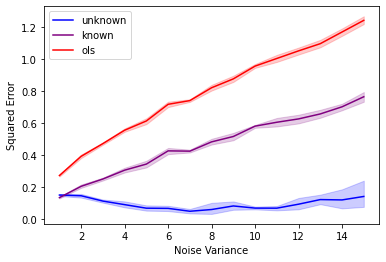

In [42]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown_, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known_, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols_, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()
# close reader
reader.close()

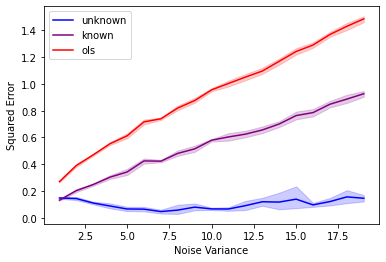

In [43]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()
# close reader
reader.close()